In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import altair as alt
import shap

from marginal import MarginalExplainer
import plot

In [3]:
n = 3000
d = 3
hidden_layers = 100
batch_size = 50
learning_rate = 0.3

In [4]:
X = np.random.randn(n, d)
y = X[:, 0] * X[:, 1] + X[:, 2]

In [5]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(d,), batch_size=batch_size))
model.add(tf.keras.layers.Dense(hidden_layers, activation=tf.keras.activations.relu, use_bias=True))
model.add(tf.keras.layers.Dense(1, activation=None, use_bias=False))

In [6]:
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MSE,
              metrics=[tf.keras.metrics.MeanAbsoluteError(), tf.keras.metrics.MeanSquaredError()])

In [7]:
model.fit(X, y, epochs=20, verbose=2)

Train on 3000 samples
Epoch 1/20
3000/3000 - 0s - loss: 0.2939 - mean_absolute_error: 0.3378 - mean_squared_error: 0.2939
Epoch 2/20
3000/3000 - 0s - loss: 0.0967 - mean_absolute_error: 0.1967 - mean_squared_error: 0.0967
Epoch 3/20
3000/3000 - 0s - loss: 0.0495 - mean_absolute_error: 0.1355 - mean_squared_error: 0.0495
Epoch 4/20
3000/3000 - 0s - loss: 0.0332 - mean_absolute_error: 0.1093 - mean_squared_error: 0.0332
Epoch 5/20
3000/3000 - 0s - loss: 0.0245 - mean_absolute_error: 0.0933 - mean_squared_error: 0.0245
Epoch 6/20
3000/3000 - 0s - loss: 0.0191 - mean_absolute_error: 0.0804 - mean_squared_error: 0.0191
Epoch 7/20
3000/3000 - 0s - loss: 0.0136 - mean_absolute_error: 0.0677 - mean_squared_error: 0.0136
Epoch 8/20
3000/3000 - 0s - loss: 0.0217 - mean_absolute_error: 0.0818 - mean_squared_error: 0.0217
Epoch 9/20
3000/3000 - 0s - loss: 0.0092 - mean_absolute_error: 0.0559 - mean_squared_error: 0.0092
Epoch 10/20
3000/3000 - 0s - loss: 0.0105 - mean_absolute_error: 0.0608 - mean

In [8]:
num_shap_samples=100

In [9]:
primal_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='mobius')
primal_effects = primal_explainer.explain(X[:num_shap_samples], verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]WARNING: Logging before flag parsing goes to stderr.
W1022 13:02:54.544668 139726224320320 base_layer.py:1814] Layer dense is casting an input tensor from dtype float64 to the layer's dtype of float32, which is new behavior in TensorFlow 2.  The layer has dtype float32 because it's dtype defaults to floatx.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

100%|██████████| 100/100 [00:06<00:00, 15.73it/s]


In [10]:
dual_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='comobius')
dual_effects = dual_explainer.explain(X[:num_shap_samples], verbose=True)

100%|██████████| 100/100 [00:06<00:00, 16.22it/s]


In [11]:
average_explainer = MarginalExplainer(model, X[num_shap_samples:], nsamples=800, representation='average')
average_effects = average_explainer.explain(X[:num_shap_samples], verbose=True)

100%|██████████| 100/100 [00:12<00:00,  8.42it/s]


In [12]:
model_func = lambda x: model(x).numpy()
kernel_explainer = shap.SamplingExplainer(model_func, X)
kernel_shap = kernel_explainer.shap_values(X[:num_shap_samples])

In [13]:
def unroll(x):
    ret = []
    for i in range(x.shape[-1]):
        ret.append(x[:, i])
    return np.concatenate(ret)

In [14]:
data_df = pd.DataFrame({
    'Sampled Primal Effects':  unroll(primal_effects),
    'Sampled Dual Effects':    unroll(dual_effects),
    'Sampled Average Effects': unroll(average_effects),
    'Kernel SHAP Values':      unroll(kernel_shap),
    'Primal Interaction Effects':  unroll(kernel_shap - primal_effects),
    'Dual Interaction Effects':    unroll(kernel_shap - dual_effects),
    'Average Interaction Effects': unroll(kernel_shap - average_effects),
    'Feature': [0] * num_shap_samples + [1] * num_shap_samples + [2] * num_shap_samples
})

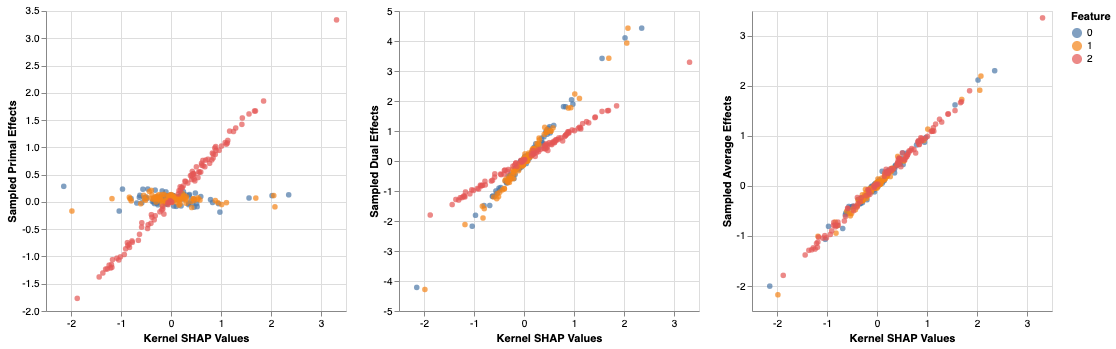

In [15]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.X('Kernel SHAP Values:Q'),
    alt.Y(alt.repeat("column"), type='quantitative'),
    alt.Color('Feature:N')
).properties(width=300, height=300).repeat(column=['Sampled Primal Effects', 'Sampled Dual Effects', 'Sampled Average Effects'])

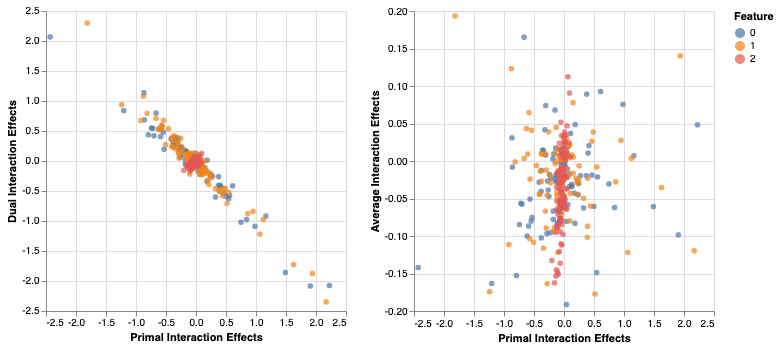

In [16]:
alt.Chart(data_df).mark_point(filled=True).encode(
    alt.X('Primal Interaction Effects:Q'),
    alt.Y(alt.repeat("column"), type='quantitative'),
    alt.Color('Feature:N')
).properties(width=300, height=300).repeat(column=['Dual Interaction Effects', 'Average Interaction Effects'])

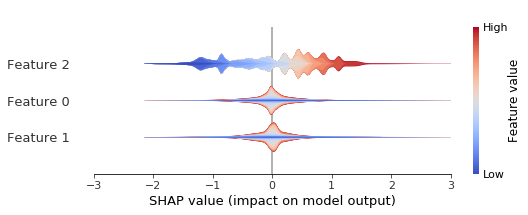

In [17]:
plot.summary_plot(kernel_shap, X[:num_shap_samples], xlim=(-3, 3), plot_type='layered_violin')

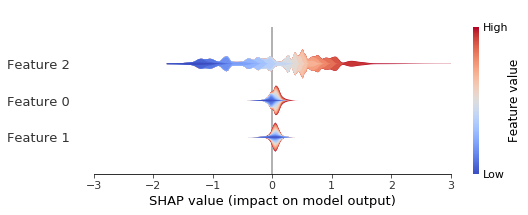

In [18]:
plot.summary_plot(primal_effects, X[:num_shap_samples], xlim=(-3, 3), plot_type='layered_violin')

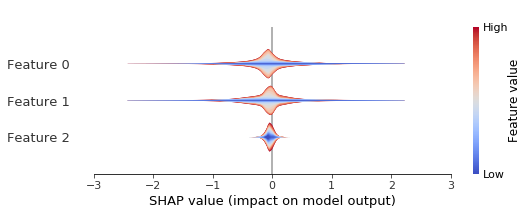

In [19]:
plot.summary_plot(kernel_shap - primal_effects, X[:num_shap_samples], xlim=(-3, 3), plot_type='layered_violin')

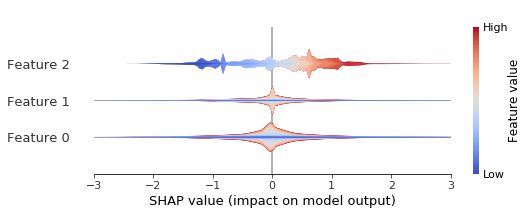

In [20]:
plot.summary_plot(dual_effects, X[:num_shap_samples], xlim=(-3, 3), plot_type='layered_violin')

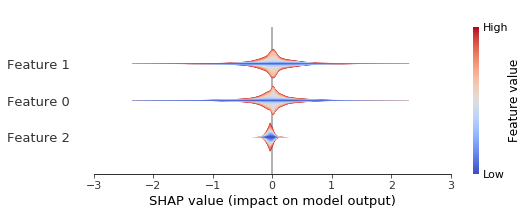

In [21]:
plot.summary_plot(kernel_shap - dual_effects, X[:num_shap_samples], xlim=(-3, 3), plot_type='layered_violin')

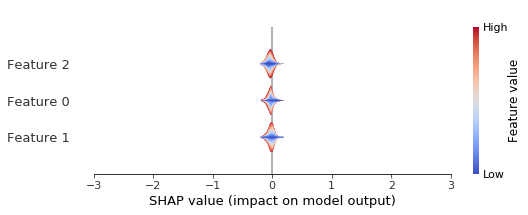

In [22]:
plot.summary_plot(kernel_shap - average_effects, X[:num_shap_samples], xlim=(-3, 3), plot_type='layered_violin')

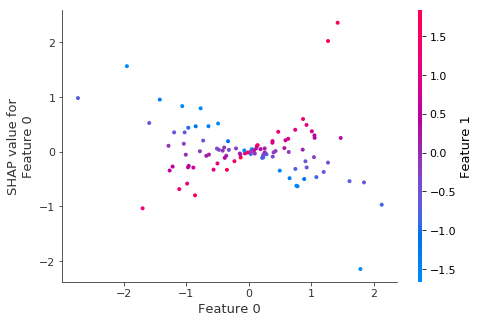

In [23]:
shap.dependence_plot(0, kernel_shap, X[:num_shap_samples])